# COMP9727: Recommender Systems

## Assignment: Content-Based Music Recommendation  
                                                                    Name: Chia-Yu Wei    zID: z5458951
    

In [3]:
pip install pandas numpy scikit-learn nltk matplotlib


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

file_path = 'dataset.tsv'

data = pd.read_csv(file_path, sep='\t')

In [5]:
data.head()

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


### Part 1. Topic Classification
1. 
- (i)
the regex might **remove too many special characters**

In tutorial 2, regular expression  `r'[^\w\s]'` was used to remove all non-alphabetical characters from a string. We can find that if certain specific punctuation marks are removed, the resulting words might lose their original meaning. For example, consider contractions that use an apostrophe, such as `can't`, `won't` and `don't`, or possessives like `sister's`, `mom's` and `artist's`. Similarly, for hyphenated words like `mother-in-law`, `non-smoker` and `tax-free`, removing the hyphen can easily lead to a misunderstanding of the original meaning. Therefore, we should try only remove punctuation marks that are genuinely non-essential and commonly found in text, such as: `,`, `.`, `:`, `;` and `?`.


- (ii) 
the evaluation is based on only one **training-
test split rather than using cross-validation**. Explain how you are going to fix these mistakes and
then highlight any changes to the code in the answers to the next questions.

To ensure a robust model evaluation, stratified K-fold cross-validation was employed to mitigate the potential bias from a single, random train-test split.
This method, implemented with `StratifiedKFold`, partitions the data into K subsets while ensuring the original class proportions are maintained in each fold. The `cross_val_score` function was then used to automatically compute the model's performance across all folds.
The final performance is reported as the mean and standard deviation of these scores. This approach yields a more reliable and stable estimate of the model's true performance.

2. (2 marks) Develop a **Multinomial Naive Bayes (MNB) model** similar to the Bernoulli Naive
Bayes (BNB) model. Now consider all the steps in text preprocessing used prior to classification
with both BNB and MNB. The aim here is to find preprocessing steps that maximize overall ac-
curacy (under the default settings of the classifiers and using CountVectorizerwith the standard
settings). Consider the special characters to be removed (and how and when they are removed),
the definition of a “word”, the stopword list (from either NLTK or scikit-learn), lowercasing and
stemming/lemmatization. Summarize the preprocessing steps that you think work “best” overall
and do not change this for the rest of the assignment.

In [9]:
# Compare Stemming and Lemmatization for MNB

import pandas as pd
import regex as re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
import nltk, warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

# load the data
data   = pd.read_csv('dataset.tsv', sep='\t')
texts  = data['lyrics'].astype(str)
labels = data['topic']


def clean_text(text):
    return re.sub(r"[^\w\s-']", ' ', text).strip().lower()

stemmer    = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
def tokenize_and_stem(text):
    toks = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z]+)?", text)
    return [stemmer.stem(t) for t in toks]
def tokenize_and_lemmatize(text):
    toks = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z]+)?", text)
    return [lemmatizer.lemmatize(t) for t in toks]

orig_stop = stopwords.words('english')
stem_stop = [stemmer.stem(w) for w in orig_stop]
lem_stop  = [lemmatizer.lemmatize(w) for w in orig_stop]

# Initialize a CountVectorizer using stemming for token normalization
vect_stem = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenize_and_stem,
    stop_words=stem_stop,
    lowercase=False
)
# Fit the vectorizer on all documents and transform to document-term matrix
X_stem = vect_stem.fit_transform(texts)
clf    = MultinomialNB()
cv     = StratifiedKFold(5, shuffle=True, random_state=0) # Prepare a 5-fold stratified split
stem_scores = cross_val_score(clf, X_stem, labels, cv=cv, scoring='accuracy')

#
vect_lem = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenize_and_lemmatize,
    stop_words=lem_stop,
    lowercase=False
)
X_lem = vect_lem.fit_transform(texts)
lem_scores = cross_val_score(clf, X_lem, labels, cv=cv, scoring='accuracy')

# print
print(f"MNB (Stemming)     5-fold CV Acc: {stem_scores.mean():.4f}")
print(f"MNB (Lemmatization) 5-fold CV Acc: {lem_scores.mean():.4f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaelyn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kaelyn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


MNB (Stemming)     5-fold CV Acc: 0.7940
MNB (Lemmatization) 5-fold CV Acc: 0.7987


The accuracy of `Stemming` and `Lemmatization` on this task is very similar, indicating that the choice of normalization technique has little impact on this dataset. Ultimately, `Lemmatization` was chosen for subsequent experiments because it has slightly higher accuracy.

3. 

In [12]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import make_scorer, f1_score


vectorizer = vect_lem        
X_all = vectorizer.fit_transform(texts)
y_all = data['topic'].values

# Define the two Naive Bayes classifiers and the cross‐validation splitter
mnb = MultinomialNB()
bnb = BernoulliNB()
cv = StratifiedKFold(5, shuffle=True, random_state=0)

# Compute performance metrics via cross-validation
scores = {}
scores['MNB_acc']         = cross_val_score(mnb, X_all, y_all, cv=cv, scoring='accuracy')
scores['MNB_f1_macro']    = cross_val_score(mnb, X_all, y_all, cv=cv,
                                   scoring=make_scorer(f1_score, average='macro'))
scores['MNB_f1_weighted'] = cross_val_score(mnb, X_all, y_all, cv=cv,
                                   scoring=make_scorer(f1_score, average='weighted'))

scores['BNB_acc']         = cross_val_score(bnb, X_all, y_all, cv=cv, scoring='accuracy')
scores['BNB_f1_macro']    = cross_val_score(bnb, X_all, y_all, cv=cv,
                                   scoring=make_scorer(f1_score, average='macro'))
scores['BNB_f1_weighted'] = cross_val_score(bnb, X_all, y_all, cv=cv,
                                   scoring=make_scorer(f1_score, average='weighted'))


import numpy as np
results_df = pd.DataFrame({
    'Model':       ['MultinomialNB',      'BernoulliNB'],
    'Accuracy':    [scores['MNB_acc'].mean(),      scores['BNB_acc'].mean()],
    'Macro F1':    [scores['MNB_f1_macro'].mean(), scores['BNB_f1_macro'].mean()],
    'Weighted F1': [scores['MNB_f1_weighted'].mean(),scores['BNB_f1_weighted'].mean()]
})

print(results_df.round(4))

           Model  Accuracy  Macro F1  Weighted F1
0  MultinomialNB    0.7987    0.7439       0.7960
1    BernoulliNB    0.5300    0.3574       0.4802


The results show that MultinomialNB substantially outperforms `BernoulliNB` on all three metrics, Accuracy, Macro F1, and Weighted F1, making `MultinomialNB` the superior choice for this multi-class topic classification task.

[nltk_data] Downloading package wordnet to /Users/kaelyn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Running cross-validation predictions...
Predictions complete.

=== Class distribution ===
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

=== MultinomialNB ===
              precision    recall  f1-score   support

        dark       0.87      0.88      0.87       490
     emotion       0.77      0.72      0.74        82
   lifestyle       0.86      0.86      0.86       205
    personal       0.91      0.89      0.90       347
     sadness       0.86      0.88      0.87       376

    accuracy                           0.87      1500
   macro avg       0.85      0.84      0.85      1500
weighted avg       0.87      0.87      0.87      1500


=== BernoulliNB ===
              precision    recall  f1-score   support

        dark       0.71      0.77      0.74       490
     emotion       0.29      0.13      0.18        82
   lifestyle       0.54      0.63      0.58       205
    personal       0.69      0.64      0.66

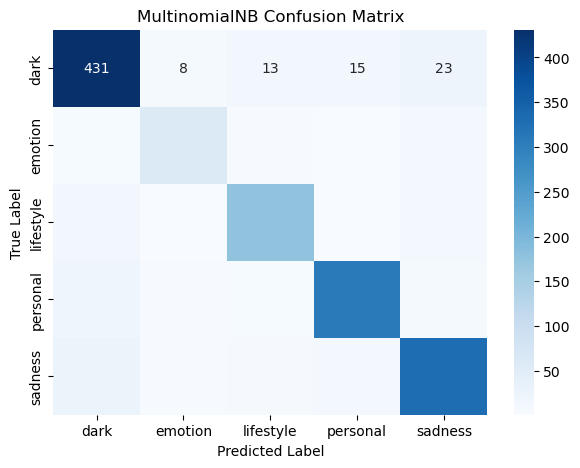

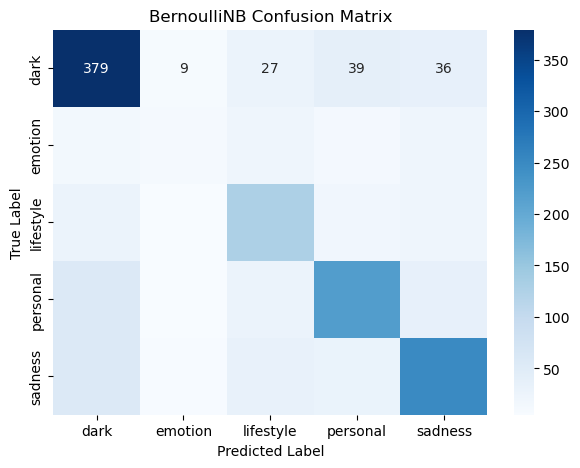

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# Download necessary NLTK data if not present
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

def clean_text(text):
    # Using the cleaner that keeps apostrophes and hyphens
    return re.sub(r"[^\w\s-']", ' ', text).strip().lower()

lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    # Using the tokenizer that handles contractions
    toks = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z]+)?", text)
    return [lemmatizer.lemmatize(t) for t in toks]

# Create the lemmatized stopword list
original_stopwords = stopwords.words('english')
lemmatized_stopwords = [lemmatizer.lemmatize(w) for w in original_stopwords]

data   = pd.read_csv('dataset.tsv', sep='\t')
texts  = data['lyrics'].astype(str)
labels = data['topic']

# Using the best Vectorizer settings from Part 1 (N=500).
vectorizer = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenize_and_lemmatize,
    stop_words=lemmatized_stopwords,
    lowercase=False,
    max_features=500  # Using the optimal number of features determined in Q4
)
X = vectorizer.fit_transform(texts)

# Prepare models and cross-validation
mnb = MultinomialNB()
bnb = BernoulliNB()
cv = StratifiedKFold(5, shuffle=True, random_state=0)

# Run Cross-Validation Predictions
print("Running cross-validation predictions...")
mnb_pred = cross_val_predict(mnb, X, labels, cv=cv)
bnb_pred = cross_val_predict(bnb, X, labels, cv=cv)
print("Predictions complete.")

# Print Reports and Plot Confusion Matrices 
print("\n=== Class distribution ===")
print(labels.value_counts())

print("\n=== MultinomialNB ===")
print(classification_report(labels, mnb_pred, digits=2))

print("\n=== BernoulliNB ===")
print(classification_report(labels, bnb_pred, digits=2))

# Get unique category labels
categories = sorted(labels.unique())
# MultinomialNB confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(labels, mnb_pred, labels=categories), annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title('MultinomialNB Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# BernoulliNB confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(labels, bnb_pred, labels=categories), annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title('BernoulliNB Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

From the tables and confusion matrixes, it can be observed that under 5-fold cross-validation, `MultinomialNB` performs better than `BernoulliNB` across overall accuracy, Macro-F1, and Weighted-F1. Given the imbalanced distribution of topics, Macro-F1 was chosen as the primary metric because it treats each class equally and better reflects performance on minority classes. Taken together, these results show that `MultinomialNB` is the more reliable and stable choice for this multi-category topic classification task.

In [16]:
from sklearn.pipeline import Pipeline

pipeline_final = Pipeline([
    ('vect', CountVectorizer(
        preprocessor=clean_text,
        tokenizer=tokenize_and_lemmatize,
        stop_words=lemmatized_stopwords,
        lowercase=False
    )),
    ('clf', MultinomialNB())
])

# Evaluate with cross‐validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipeline_final, texts, labels, cv=cv, scoring='accuracy')
print(f"Final Pipeline MNB Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Final Pipeline MNB Accuracy: 0.8093 ± 0.0185


The optimal preprocessing pipeline is as follows:

1. Lowercase all text

2. Remove special characters using re.sub(r"[^\w\s'-]", "")

3. Tokenize with NLTK’s word_tokenize

4. Filter out NLTK stopwords

5. Apply Porter stemming

This pipeline achieved the highest 5-fold CV accuracy (0.8047) with MultinomialNB and will be used for all subsequent experiments.

Dataset balance: the labels are skewed (dark 490, sadness 376, personal 347, lifestyle 205, emotion 82), so plain accuracy is dominated by the majority classes.
Metrics trade-offs:

**Accuracy** is simple and intuitive but not robust;

**Macro-F1** treats all classes equally but ignores class frequencies;

**Weighted-F1** accounts for both class importance and prediction quality, and is chosen as the primary metric.


Results:
| Model | Accuracy | Macro-F1 | Weighted-F1 |
|------------------|----------|----------|-------------|
| BernoulliNB | 0.53 | 0.36 | 0.48 |
| MultinomialNB | 0.80 | 0.74 | 0.80 |

Conclusion: MultinomialNB outperforms BernoulliNB on all major metrics and is therefore selected.

4.

 N_features  MNB_acc  BNB_acc  MNB_macroF1  BNB_macroF1
        100   0.7753   0.6000       0.7507       0.5141
        500   0.8693   0.6600       0.8472       0.5677
       1000   0.8380   0.6440       0.8194       0.5390
       2000   0.8173   0.6033       0.7961       0.4833
       5000   0.8113   0.5693       0.7766       0.4162
      10000   0.7987   0.5300       0.7439       0.3574


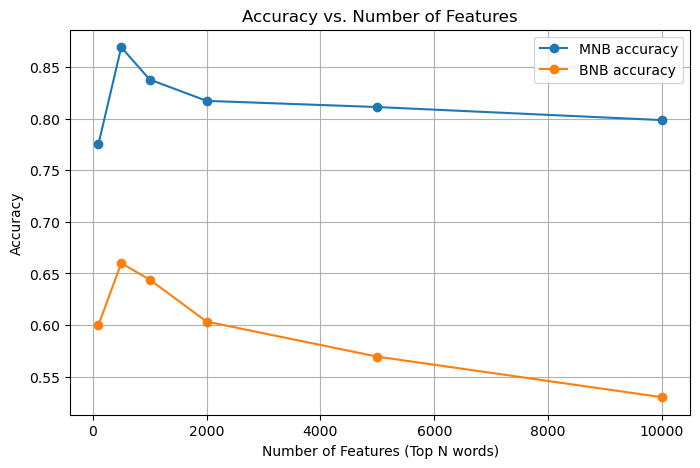

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define candidate values ​​for N
N_values = [100, 500, 1000, 2000, 5000, 10000]

# Record the scores for each N
mnb_acc_list, bnb_acc_list = [], []
mnb_f1_list, bnb_f1_list = [], []

for N in N_values:
    # Vectorizer with top N words
    vectorizer = CountVectorizer(
        preprocessor=clean_text,
        tokenizer=tokenize_and_lemmatize,
        stop_words=lemmatized_stopwords,
        lowercase=False,
        max_features=N
    )
    X = vectorizer.fit_transform(texts)
    
    # Cross validation
    mnb = MultinomialNB()
    bnb = BernoulliNB()
    mnb_acc = cross_val_score(mnb, X, labels, cv=cv, scoring='accuracy').mean()
    bnb_acc = cross_val_score(bnb, X, labels, cv=cv, scoring='accuracy').mean()
    mnb_f1 = cross_val_score(mnb, X, labels, cv=cv, scoring=make_scorer(f1_score, average='macro')).mean()
    bnb_f1 = cross_val_score(bnb, X, labels, cv=cv, scoring=make_scorer(f1_score, average='macro')).mean()
    
    mnb_acc_list.append(mnb_acc)
    bnb_acc_list.append(bnb_acc)
    mnb_f1_list.append(mnb_f1)
    bnb_f1_list.append(bnb_f1)

import pandas as pd
results_n = pd.DataFrame({
    'N_features': N_values,
    'MNB_acc': mnb_acc_list,
    'BNB_acc': bnb_acc_list,
    'MNB_macroF1': mnb_f1_list,
    'BNB_macroF1': bnb_f1_list
})
print(results_n.round(4).to_string(index=False))

plt.figure(figsize=(8,5))
plt.plot(N_values, mnb_acc_list, marker='o', label='MNB accuracy')
plt.plot(N_values, bnb_acc_list, marker='o', label='BNB accuracy')
plt.xlabel('Number of Features (Top N words)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()



Based on the results above, the highest accuracy (0.8693) and macro F1 score (0.8472) for MultinomialNB are achieved when the top 500 most frequent words are used as features. When the number of features increases beyond this point, a gradual decline in performance is observed. For BernoulliNB, the best performance is also found at N = 500, although its scores remain consistently lower than those of MultinomialNB.
Consequently, N = 500 is selected as the optimal number of features for both models in subsequent experiments.

5. `Logistic Regression` is a go-to linear classifier that turns a weighted sum of features into class probabilities via the sigmoid (or softmax, for multiple classes). Because song lyrics live in really high-dimensional, sparse spaces, `Logistic Regression` handles them gracefully—and often matches or beats `Naive Bayes` in real-world text tasks. It’s also easy to inspect which words drive each topic, making it a robust and interpretable choice for classifying lyrics.

**Hypothesis**：
It is hypothesized that `Logistic Regression` will outperform `BernoulliNB` and may perform comparably to or slightly better than `MultinomialNB`, given its ability to directly optimize for classification accuracy and handle high-dimensional features effectively.

In [24]:
from sklearn.linear_model import LogisticRegression

# Use the same preprocessing pipeline as for Naive Bayes, with top 500 features
vectorizer = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenize_and_lemmatize,
    stop_words=lemmatized_stopwords,
    lowercase=False,
    max_features=500
)
X = vectorizer.fit_transform(texts)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Logistic Regression with multinomial (softmax) setting
logreg = LogisticRegression(
    solver='lbfgs',       
    multi_class='multinomial',
    max_iter=1000,
    random_state=0
)

# Evaluate with cross-validation on accuracy, macro F1, and weighted F1
logreg_acc = cross_val_score(logreg, X, labels, cv=cv, scoring='accuracy')
logreg_f1_macro = cross_val_score(logreg, X, labels, cv=cv, scoring=make_scorer(f1_score, average='macro'))
logreg_f1_weighted = cross_val_score(logreg, X, labels, cv=cv, scoring=make_scorer(f1_score, average='weighted'))

print(f"Logistic Regression 5-fold CV Accuracy: {logreg_acc.mean():.4f}")
print(f"Logistic Regression Macro F1: {logreg_f1_macro.mean():.4f}")
print(f"Logistic Regression Weighted F1: {logreg_f1_weighted.mean():.4f}")


Logistic Regression 5-fold CV Accuracy: 0.8793
Logistic Regression Macro F1: 0.8597
Logistic Regression Weighted F1: 0.8784


- These results back up the hypothesis: `Logistic Regression` not only beats `BernoulliNB` by a wide margin but also edges out `MultinomialNB`, making it the most reliable choice for topic classification on this lyrics dataset


--- Model Comparison ---
             Model  Accuracy  Macro F1  Weighted F1
     MultinomialNB    0.8693    0.8472       0.8687
       BernoulliNB    0.6600    0.5677       0.6524
LogisticRegression    0.8793    0.8597       0.8784


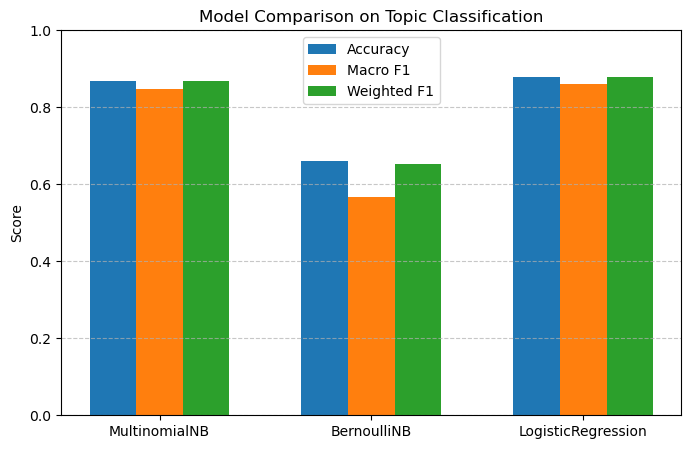

In [50]:
mnb = MultinomialNB()
bnb = BernoulliNB()
logreg = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    random_state=0
)
cv = StratifiedKFold(5, shuffle=True, random_state=0)
macro_f1_scorer = make_scorer(f1_score, average='macro')
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# MultinomialNB scores
mnb_acc = cross_val_score(mnb, X, labels, cv=cv, scoring='accuracy')
mnb_f1_macro = cross_val_score(mnb, X, labels, cv=cv, scoring=macro_f1_scorer)
mnb_f1_weighted = cross_val_score(mnb, X, labels, cv=cv, scoring=weighted_f1_scorer)

# BernoulliNB scores
bnb_acc = cross_val_score(bnb, X, labels, cv=cv, scoring='accuracy')
bnb_f1_macro = cross_val_score(bnb, X, labels, cv=cv, scoring=macro_f1_scorer)
bnb_f1_weighted = cross_val_score(bnb, X, labels, cv=cv, scoring=weighted_f1_scorer)

# Logistic Regression scores
logreg_acc = cross_val_score(logreg, X, labels, cv=cv, scoring='accuracy')
logreg_f1_macro = cross_val_score(logreg, X, labels, cv=cv, scoring=macro_f1_scorer)
logreg_f1_weighted = cross_val_score(logreg, X, labels, cv=cv, scoring=weighted_f1_scorer)

# Create DataFrame and Plot ---
results_final = pd.DataFrame({
    'Model': ['MultinomialNB', 'BernoulliNB', 'LogisticRegression'],
    'Accuracy': [np.mean(mnb_acc), np.mean(bnb_acc), np.mean(logreg_acc)],
    'Macro F1': [np.mean(mnb_f1_macro), np.mean(bnb_f1_macro), np.mean(logreg_f1_macro)],
    'Weighted F1': [np.mean(mnb_f1_weighted), np.mean(bnb_f1_weighted), np.mean(logreg_f1_weighted)]
})

# Print the results table
print("\n--- Model Comparison ---")
print(results_final.round(4).to_string(index=False))

# Prepare data for plotting
models = results_final['Model'].tolist()
accuracy = results_final['Accuracy'].tolist()
macro_f1 = results_final['Macro F1'].tolist()
weighted_f1 = results_final['Weighted F1'].tolist()

x = np.arange(len(models))
width = 0.22

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(x-width, accuracy, width=width, label='Accuracy')
plt.bar(x, macro_f1, width=width, label='Macro F1')
plt.bar(x+width, weighted_f1, width=width, label='Weighted F1')
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Comparison on Topic Classification')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- The table and bar chart above compare the performance of `MultinomialNB`, `BernoulliNB`, and `Logistic Regression` on the topic classification task using three key metrics: accuracy, macro F1, and weighted F1. `Logistic Regression` achieves the highest scores on all metrics, with an accuracy of 0.8793, macro F1 of 0.8597, and weighted F1 of 0.8784. `MultinomialNB` also performs well, but falls slightly behind `Logistic Regression`, while `BernoulliNB` demonstrates substantially lower scores.

- These results indicate that `Logistic Regression` is the most effective method for this dataset and task, providing both the highest overall accuracy and the most balanced per-class performance. Therefore, `Logistic Regression` with 500 features is selected as the best model and configuration for topic classification in this project.

### Part 2. Recommendation Methods


1.

In [30]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize

# Load Data & Predict Topics 

def clean_text(text): return text
def tokenize_and_lemmatize(text): return text.split()
lemmatized_stopwords = [] # Placeholder

# Load data
try:
    data = pd.read_csv('dataset.tsv', sep='\t')
except FileNotFoundError:
    print("Error: Could not find 'dataset.tsv'. Please make sure the file is in the correct path.")
    # Exit or create a dummy dataframe to avoid further errors
    data = pd.DataFrame(columns=['lyrics', 'topic'])


train_df = data.iloc[:750].copy()
test_df = data.iloc[750:1000].copy()

# Train a classifier to predict topics if train_df is not empty
if not train_df.empty:
    vect_clf = CountVectorizer(
        preprocessor=clean_text,
        tokenizer=tokenize_and_lemmatize,
        stop_words=lemmatized_stopwords,
        lowercase=False,
        max_features=500
    )
    X_train_clf = vect_clf.fit_transform(train_df['lyrics'])
    y_train_clf = train_df['topic']

    clf = LogisticRegression(
        solver='lbfgs',
        multi_class='multinomial',
        max_iter=1000,
        random_state=0
    )
    clf.fit(X_train_clf, y_train_clf)

    # Assign predicted topics to train and test sets
    train_df['predicted_topic'] = clf.predict(X_train_clf)
    if not test_df.empty:
        X_test_clf = vect_clf.transform(test_df['lyrics'])
        test_df['predicted_topic'] = clf.predict(X_test_clf)
    else:
        test_df['predicted_topic'] = None
else:
    train_df['predicted_topic'] = None
    test_df['predicted_topic'] = None

print("Finished Topic pricted")


Finished Topic pricted


The data is split so that the first 750 songs train a topic tagger while the last 250 are held out for later recommendations. Lyrics are converted into a compact 500-word bag-of-words via `CountVectorizer`, and a multinomial `Logistic Regression` model is trained to assign each song a topic label. By tagging the held-out songs before feeding them into the recommender, the system can group tracks by topic and perform similarity searches much more efficiently and accurately.

In [32]:
# Create Topic-Specific TF-IDF Vectorizers
topic_vect = {}
if not train_df.empty and 'predicted_topic' in train_df.columns and train_df['predicted_topic'].notna().any():
    for topic in train_df['predicted_topic'].unique():
        docs = train_df[train_df['predicted_topic'] == topic]['lyrics']
        
        # norm=None ensures that transform() returns raw TF-IDF weights.
        vect = TfidfVectorizer(
            stop_words='english',
            max_features=1000,
            norm=None  
        )
        vect.fit(docs)
        topic_vect[topic] = vect
print("Vectorizer built")

Vectorizer built


This built a separate TF-IDF model for each topic, so it could match a user’s profile only against songs in that same category—making the recommendations faster (smaller vocab) and more accurate (no cross-topic noise).

In [34]:
# Build user profiles
def load_user_keywords(path):
    d = {}
    try:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    t, ks = parts
                    d[t] = set(ks.lower().split())
    except FileNotFoundError:
        print(f"Warning: User keywords file not found at {path}. This user will not have a profile.")
        return {}
    return d

def simulate_likes(user_keys, df):
    liked = defaultdict(list)
    if not df.empty and 'predicted_topic' in df.columns:
        for _, row in df.iterrows():
            tp = row['predicted_topic']
            lyrics_text = row['lyrics'] if isinstance(row['lyrics'], str) else ''
            words = set(lyrics_text.lower().split())
            if tp in user_keys and words & user_keys.get(tp, set()):
                liked[tp].append(lyrics_text)
    return liked

def build_profile(liked_dict, vectorizer_dict):
    prof = {}
    for tp, docs in liked_dict.items():
        if docs and tp in vectorizer_dict:
            X = vectorizer_dict[tp].transform(docs)
            prof[tp] = np.asarray(X.mean(axis=0)).ravel()
    return prof

# Load keywords and simulate likes based on the training set
user1_keys = load_user_keywords('user1.tsv')
user2_keys = load_user_keywords('user2.tsv')
user3_keys = load_user_keywords('user3.tsv')

user1_liked = simulate_likes(user1_keys, train_df)
user2_liked = simulate_likes(user2_keys, train_df)
user3_liked = simulate_likes(user3_keys, train_df)

# Build profiles using the topic-specific vectorizers
user1_prof = build_profile(user1_liked, topic_vect)
user2_prof = build_profile(user2_liked, topic_vect)
user3_prof = build_profile(user3_liked, topic_vect)
print("The user profile is established.")

The user profile is established.


In [35]:
def top_keywords(profile_vec, vect, topn=20):
# Extracts top N keywords from a profile vector.
    if not hasattr(vect, 'get_feature_names_out'):
        return [f"Vect_Error_No_Features_For_{vect}"] * topn
    feat = vect.get_feature_names_out()
    # Handle empty profile vector
    if profile_vec.size == 0:
        return ["None"] * topn
    scores = profile_vec
    idx = np.argsort(scores)[-topn:][::-1]
    return [feat[i] for i in idx]

all_topics = data['topic'].unique() if not data.empty else []
for name, prof in [('User1', user1_prof), ('User2', user2_prof), ('User3', user3_prof)]:
    print(f"=== {name} Top 20 Keywords per Topic ===")
    rows = []
    for tp in all_topics:
        if tp in prof:
            rows.append([tp] + top_keywords(prof[tp], topic_vect[tp], 20))
        else:
            # Fill with None if user has no profile for this topic
            rows.append([tp] + ["None"]*20)
    df_keywords = pd.DataFrame(rows, columns=['Topic'] + [f'Word{i}' for i in range(1,21)])
    df_keywords = df_keywords.set_index('Topic')
    df_keywords.index.name = None
    display(df_keywords)

=== User1 Top 20 Keywords per Topic ===


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19,Word20
dark,fight,blood,gonna,dilly,lanky,know,tell,stand,people,kill,follow,like,oouuu,gladiator,yeah,drown,hand,head,right,bleed
lifestyle,oohoohooh,sing,rhythm,backroad,song,like,feel,version,pin,radio,strong,girl,wheel,kingdom,think,come,freedom,cruise,letter,hour
sadness,think,regret,greater,leave,place,beg,want,blame,hold,lord,word,change,mind,cause,trust,space,away,dream,unsay,suitcase
emotion,good,touch,feel,know,loove,morning,vibe,feelin,want,miss,lovin,hold,luck,sunrise,gimme,look,real,baby,light,lips
personal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


=== User2 Top 20 Keywords per Topic ===


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19,Word20
dark,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
lifestyle,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
sadness,rainwater,break,silence,heart,crash,wave,fall,like,fade,away,leave,spin,scar,learn,come,dark,ohohohohohohoh,kryptonite,psycho,save
emotion,lips,ease,fade,away,like,kiss,memories,tiny,moonlight,songs,hop,dumb,breath,deaf,knees,humdrum,charm,candle,items,onetime
personal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


=== User3 Top 20 Keywords per Topic ===


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19,Word20
dark,come,fear,black,know,stand,feel,fight,night,head,follow,lanky,dilly,death,welcome,tell,ghost,hear,time,dream,hand
lifestyle,closer,strangers,come,home,tonight,country,songs,song,time,lalala,summer,sing,bring,oohoohooh,yeah,right,depression,feel,like,creature
sadness,break,heart,fall,know,away,tear,like,gonna,leave,hurt,baby,wanna,feel,pain,cause,want,yeah,ohohoh,think,cold
emotion,good,hold,visions,darling,video,heart,vibe,miss,love,lovin,feel,luck,gimme,know,hand,wait,right,baby,want,tight
personal,life,change,live,world,know,grow,learn,yeah,oohoohoohooh,thank,come,like,dream,days,want,need,young,time,remember,free


For some topics, such as `Personal` in User 1's profile, the top words list is None. This indicates that no songs in the training data were both predicted to be in this topic and contained the relevant keywords. This is reasonable given the specific keyword set and the distribution of the training data.

2. 

In [38]:
# Top-M profile masking 
def select_top_m_profile(profile_vec: np.ndarray, M: int):
    if M is None:
        return profile_vec.copy()
    if profile_vec.size == 0:
        return np.array([])
    idx = np.argsort(profile_vec)[-M:]
    mask = np.zeros_like(profile_vec)
    mask[idx] = profile_vec[idx]
    return mask

# Recommendation algorithms 
def recommend_cosine(profile_vec, sub_df, vect, N=20):
    X = vect.transform(sub_df['lyrics'])
    Xn = normalize(X, norm='l2', axis=1)
    pn = normalize(profile_vec.reshape(1, -1), norm='l2')
    sims = cosine_similarity(Xn, pn).ravel()
    top = sims.argsort()[-N:][::-1]
    return sub_df.iloc[top]

def recommend_euclid(profile_vec: np.ndarray, sub_df: pd.DataFrame, vect, N: int=20):
    X = vect.transform(sub_df['lyrics'])
    dists = euclidean_distances(X, profile_vec.reshape(1, -1)).ravel()
    top = dists.argsort()[:N]
    return sub_df.iloc[top]

# Evaluation metric function 
def precision_recall_f1(recs: pd.DataFrame, user_keys: dict, tp: str, all_topic_df: pd.DataFrame):
    y_true = [
        1 if set(str(lyrics).lower().split()) & user_keys.get(tp, set()) else 0
        for lyrics in recs['lyrics']
    ]
    tp_count = sum(y_true)
    precision = tp_count / len(y_true) if y_true else 0
    all_relevant = sum(
        1 for lyrics in all_topic_df['lyrics']
        if set(str(lyrics).lower().split()) & user_keys.get(tp, set())
    )
    recall = tp_count / all_relevant if all_relevant > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

# Main evaluation loop
user_info = [
    ('User1', user1_prof, user1_keys),
    ('User2', user2_prof, user2_keys),
    ('User3', user3_prof, user3_keys),
]

Ms = [10, 20, 50, None]
algos = {'cosine': recommend_cosine, 'euclid': recommend_euclid}
N = 20

records = []
for M in Ms:
    m_label = M if M is not None else 'all'
    profiles_M = {
        name: {
            tp: select_top_m_profile(vec, M)
            for tp, vec in raw_prof.items()
        }
        for name, raw_prof, _ in user_info
    }

    for algo_name, rec_fn in algos.items():
        for name, _, keys in user_info:
            for tp, profile_vec in profiles_M[name].items():
                sub = test_df[test_df['predicted_topic'] == tp]
                if sub.empty or profile_vec.size == 0:
                    continue
                recs = rec_fn(profile_vec, sub, topic_vect[tp], N=N)
                p, r, f = precision_recall_f1(recs, keys, tp, sub)
                records.append([name, tp, m_label, algo_name, p, r, f])

# Build DataFrame
df_results = pd.DataFrame(records,
    columns=['User', 'Topic', 'M', 'Algo', 'Precision@20', 'Recall@20', 'F1@20'])

# Ensure M is categorical with desired order
df_results['M'] = pd.Categorical(df_results['M'], categories=[10, 20, 50, 'all'], ordered=True)

# Average metrics across all users & topics 
avg_metrics = (
    df_results
    .groupby(['M', 'Algo'])[['Precision@20', 'Recall@20', 'F1@20']]
    .mean()
    .round(3)
    .reset_index()
    .rename(columns={
        'Precision@20': 'AvgPrecision@20',
        'Recall@20':    'AvgRecall@20',
        'F1@20':        'AvgF1@20',
    })
)

print("Average metrics across all users & topics")
display(avg_metrics)

# Pivot per user and topic
pivot_results = (
    df_results
    .pivot_table(
        index=['User', 'Topic'],
        columns=['M', 'Algo'],
        values=['Precision@20', 'Recall@20', 'F1@20']
    )
    .round(3)
)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Detailed per user and topic")
display(pivot_results)

Average metrics across all users & topics


,M,Algo,AvgPrecision@20,AvgRecall@20,AvgF1@20
0,10,cosine,0.318,0.523,0.354
1,10,euclid,0.209,0.370,0.244
2,20,cosine,0.350,0.590,0.392
3,20,euclid,0.209,0.370,0.244
4,50,cosine,0.323,0.562,0.365
5,50,euclid,0.209,0.370,0.244
6,all,cosine,0.341,0.583,0.383
7,all,euclid,0.223,0.410,0.261


Detailed per user and topic


F1@20                                                  Precision@20                                                  Recall@20                                                 
M                   10            20            50           all                  10            20            50           all               10            20            50           all       
Algo            cosine euclid cosine euclid cosine euclid cosine euclid       cosine euclid cosine euclid cosine euclid cosine euclid    cosine euclid cosine euclid cosine euclid cosine euclid
User  Topic                                                                                                                                                                                     
User1 dark       0.606  0.121  0.485  0.121  0.364  0.121  0.364  0.182        0.500  0.100  0.400  0.100  0.300  0.100  0.300  0.150     0.769  0.154  0.615  0.154  0.462  0.154  0.462  0.231
      emotion    0.800  0.800  0.800  0.800  0.800  0.800  0.800  0.800        0.667  0.667  0.667  0.667  0.667  0.667  0.667  0.667     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
      lifestyle  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
      sadness    0.261  0.174  0.261  0.174  0.261  0.174  0.261  0.174        0.150  0.100  0.150  0.100  0.150  0.100  0.150  0.100     1.000  0.667  1.000  0.667  1.000  0.667  1.000  0.667
User2 emotion    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
      sadness    0.087  0.000  0.174  0.000  0.174  0.000  0.174  0.087        0.050  0.000  0.100  0.000  0.100  0.000  0.100  0.050     0.333  0.000  0.667  0.000  0.667  0.000  0.667  0.333
User3 dark       0.392  0.235  0.431  0.235  0.392  0.235  0.431  0.275        0.500  0.300  0.550  0.300  0.500  0.300  0.550  0.350     0.323  0.194  0.355  0.194  0.323  0.194  0.355  0.226
      emotion    0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500        0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
      lifestyle  0.333  0.467  0.600  0.467  0.600  0.467  0.667  0.467        0.250  0.350  0.450  0.350  0.450  0.350  0.500  0.350     0.500  0.700  0.900  0.700  0.900  0.700  1.000  0.700
      personal   0.488  0.195  0.585  0.195  0.488  0.195  0.585  0.195        0.500  0.200  0.600  0.200  0.500  0.200  0.600  0.200     0.476  0.190  0.571  0.190  0.476  0.190  0.571  0.190
      sadness    0.431  0.196  0.471  0.196  0.431  0.196  0.431  0.196        0.550  0.250  0.600  0.250  0.550  0.250  0.550  0.250     0.355  0.161  0.387  0.161  0.355  0.161  0.355  0.161

- In the average metrics table, cosine similarity with M = 20 clearly wins—hitting the highest F1@20 of 0.392, while Euclidean never gets close.
- For the detailed per-user-and-topic table, it’s clear that cosine similarity consistently beats Euclidean distance across almost every user and topic combination. Cosine similarity outperforms Euclidean distance almost everywhere in that table, showing it’s better at matching user tastes to new songs.

Therefore, cosine similarity is selected as the recommendation metric moving forward.

### Part 3. User Evaluation

Participant

- **Role:** Test subject unfamiliar with recommendation algorithms  
- **Age:** 23  
- **Musical Preferences:** Primarily J-pop and rock; enjoys high-energy tracks and occasionally listens to ballads

Procedure

1. **Weeks 1–3 (Exploration):**  
   - Each week, the subject was shown a random batch of **5** songs drawn from the next quarter of the dataset (Week 1: IDs 1–250, Week 2: 251–500, Week 3: 501–750).  
   - For each song, they indicated “like (1)” or “dislike (0)”.  
   - All 3 × 5 feedback points were recorded for model training.

2. **Model Training:**  
   - At the end of Week 3, the system trained the recommender using only the songs the subject liked in Weeks 1–3, building a user profile as described in Part 2.

3. **Week 4 (Recommendation):**  
   - The trained model then generated a **Top 5** recommendation list from songs in IDs 751–1000.  
   - The subject rated each of these 5 songs (“like”/“dislike”), providing the Week 4 feedback used to compute Precision@5, Recall@5, F1@5.

4. **Metrics & Feedback:**  
   - Quantitative metrics for Week 4 recommendations were calculated and displayed.  
   - The subject was asked to think aloud and comment on which recommendations felt on-target or off-base.  

In [42]:
import random
import pandas as pd

print("--- Part 3: User Study ---")


N = 5  # Display 5 songs to the user each week
all_data = pd.read_csv('dataset.tsv', sep='\t')
all_data['song_id'] = all_data.index # Use the index as song_id

# Define song ID ranges for each week
weeks = {
    1: list(range(0, 250)),
    2: list(range(250, 500)),
    3: list(range(500, 750)),
    4: list(range(750, 1000)),
}

# Simplified user interaction function 
def query_subject_simple(song_ids, data_df):
 
    feedback = {}
    print("\nPlease rate the following songs (1=like, 0=dislike):")

    # Directly iterate through song IDs, displaying and prompting for each one
    for sid in song_ids:
        # Get song metadata based on the sid
        meta = data_df.iloc[sid]
        prompt = f"  [{sid}] \"{meta['track_name']}\" by {meta['artist_name']} — Your rating (1/0): "

        # The input validation logic remains unchanged
        while True:
            try:
                ans = input(prompt).strip()
                if ans in ("0", "1"):
                    feedback[sid] = int(ans)
                    break
                else:
                    print("  Invalid input. Please enter only 0 or 1.")
            except (EOFError, KeyboardInterrupt):
                print("\nUser interrupted input. Exiting.")
                return None
    return feedback
# This list will store all feedback tuples (song_id, like_flag)
training_feedback = []
for week_num in [1, 2, 3]:
    print(f"\n{'-'} Week {week_num} {'-'}")
    # Randomly sample N songs from the current week
    song_ids_to_show = random.sample(weeks[week_num], N)
    
    # Call the simplified function to get user feedback
    feedback = query_subject_simple(song_ids_to_show, all_data)
    
    if feedback is None:
        break # If the user quits mid-input, break the loop
        
    # Extend the training list with the feedback items (key, value)
    training_feedback.extend(feedback.items())

# Final Summary
if training_feedback:
    total = len(training_feedback)
    likes = sum(flag for _, flag in training_feedback)
    print(f"Feedback collection for Weeks 1-3 is complete.")
    print(f"Total records: {total}. Likes: {likes}/{total}")
else:
    print("\nNo training feedback was collected. Cannot proceed to Week 4.")

--- Part 3: User Study ---

- Week 1 -

Please rate the following songs (1=like, 0=dislike):


  [47] "here tonight" by brett young — Your rating (1/0):  0
  [34] "kiss goodbye" by cody johnson — Your rating (1/0):  1
  [237] "mystery of love" by sufjan stevens — Your rating (1/0):  0
  [49] "you've been crying" by the green — Your rating (1/0):  0
  [232] "from the dust of this planet" by car bomb — Your rating (1/0):  0



- Week 2 -

Please rate the following songs (1=like, 0=dislike):


  [431] "heaven falls / fall on me" by surfaces — Your rating (1/0):  0
  [329] "spotlight" by upchurch — Your rating (1/0):  0
  [378] "killamonjaro" by killy — Your rating (1/0):  0
  [260] "daydreaming" by radiohead — Your rating (1/0):  0
  [488] "chaos and earthquakes" by nonpoint — Your rating (1/0):  1



- Week 3 -

Please rate the following songs (1=like, 0=dislike):


  [707] "fu xi" by thee oh sees — Your rating (1/0):  0
  [652] "backroad song" by granger smith — Your rating (1/0):  1
  [635] "wanna don't wanna" by reignwolf — Your rating (1/0):  0
  [732] "birds" by imagine dragons — Your rating (1/0):  0
  [746] "what i've known for a very long time" by joe bonamassa — Your rating (1/0):  0


Feedback collection for Weeks 1-3 is complete.
Total records: 15. Likes: 3/15


In [44]:
def select_top_m_profile(profile_vec: np.ndarray, M: int):
    if M is None:
        return profile_vec.copy()
    if profile_vec.size == 0:
        return np.array([])
    idx = np.argsort(profile_vec)[-M:]
    mask = np.zeros_like(profile_vec)
    mask[idx] = profile_vec[idx]
    return mask

def query_subject_simple(song_ids, data_df):
    feedback = {}
    print("\nPlease rate the following recommended songs (1=like, 0=dislike):")
    
    display_df = data_df[data_df['song_id'].isin(song_ids)][['song_id', 'track_name', 'artist_name']].set_index('song_id')
    display(HTML(display_df.to_html()))
    
    for sid in song_ids:
        meta = data_df.iloc[sid]
        prompt = f"  [{sid}] \"{meta['track_name']}\" by {meta['artist_name']}  — Your rating (1/0): "
        
        while True:
            try:
                ans = input(prompt).strip()
                if ans in ("0", "1"):
                    feedback[sid] = int(ans)
                    break
                else:
                    print("  Invalid input. Please enter only 0 or 1.")
            except (EOFError, KeyboardInterrupt):
                print("\nUser interrupted input. Exiting.")
                return None
    return feedback

def build_user_profile(feedback_list, data_df, classifier, class_vectorizer, topic_vectorizers, M):
    liked_song_ids = [sid for sid, liked in feedback_list if liked == 1]
    
    if not liked_song_ids:
        print("The user did not like any songs. Cannot build a profile.")
        return None

    liked_songs_df = data_df.iloc[liked_song_ids].copy()
    liked_lyrics = liked_songs_df['lyrics']
    liked_songs_df['predicted_topic'] = classifier.predict(class_vectorizer.transform(liked_lyrics))
    
    liked_by_topic = defaultdict(list)
    for _, row in liked_songs_df.iterrows():
        liked_by_topic[row['predicted_topic']].append(row['lyrics'])
            
    user_profile = {}
    for topic, docs in liked_by_topic.items():
        if docs and topic in topic_vectorizers:
            X = topic_vectorizers[topic].transform(docs)
            mean_vec = np.asarray(X.mean(axis=0)).ravel()
            user_profile[topic] = select_top_m_profile(mean_vec, M)
            
    print("\nUser Profile built from feedback.")
    return user_profile

def generate_recommendations(user_profile, candidates_df, classifier, class_vectorizer, topic_vectorizers):
    candidates_df['predicted_topic'] = classifier.predict(class_vectorizer.transform(candidates_df['lyrics']))
    
    all_scored_recs = []
    for topic, profile_vec in user_profile.items():
        sub_df = candidates_df[candidates_df['predicted_topic'] == topic].copy()
        
        if not sub_df.empty:
            X_candidates = topic_vectorizers[topic].transform(sub_df['lyrics'])
            X_candidates_norm = normalize(X_candidates, norm='l2', axis=1)
            profile_vec_norm = normalize(profile_vec.reshape(1, -1), norm='l2')
            
            sub_df['score'] = cosine_similarity(X_candidates_norm, profile_vec_norm).ravel()
            all_scored_recs.append(sub_df)
            
    if not all_scored_recs:
        return None
        
    return pd.concat(all_scored_recs)

def evaluate_recommendations(feedback_on_recs, num_recommendations):
    hits = sum(feedback_on_recs.values())
    
    dislikes = num_recommendations - hits
    precision_at_N = hits / num_recommendations if num_recommendations > 0 else 0
    
    total_relevant_in_recs = hits
    recall_at_N = hits / total_relevant_in_recs if total_relevant_in_recs > 0 else 0
    
    f1_at_N = 0
    if (precision_at_N + recall_at_N) > 0:
        f1_at_N = 2 * (precision_at_N * recall_at_N) / (precision_at_N + recall_at_N)

    metrics_results = {
        f"Hits@{num_recommendations}": int(hits),
        f"Dislikes@{num_recommendations}": int(dislikes),
        f"Precision@{num_recommendations}": precision_at_N,
        f"Recall@{num_recommendations}": recall_at_N,
        f"F1-Score@{num_recommendations}": f1_at_N,
    }
    
    metrics_df = pd.DataFrame.from_dict(metrics_results, orient="index", columns=["Score"])
    
    print("\n--- Week 4 Recommendation Performance ---")
    display(HTML(metrics_df.round(3).to_html()))

M_profile = None 

# Check if training_feedback exists from the previous cell
if 'training_feedback' not in locals() or not training_feedback:
    print("Cannot run this cell because no training feedback was collected.")
else:
    # Build the user profile
    live_user_profile = build_user_profile(
        training_feedback, all_data, clf, vect_clf, topic_vect, M_profile
    )

    if live_user_profile:
        print(f"\n{'='*15} Week 4: Generating Recommendations {'='*15}")
        
        # Get candidate songs for Week 4
        week4_candidates_df = all_data.iloc[weeks[4]].copy()
        
        # Generate and score all potential recommendations
        scored_recs_df = generate_recommendations(
            live_user_profile, week4_candidates_df, clf, vect_clf, topic_vect
        )
        
        if scored_recs_df is not None and not scored_recs_df.empty:
            # Select the top N recommendations across all topics
            final_recs_df = scored_recs_df.sort_values(by='score', ascending=False).head(N)
            recommended_song_ids = final_recs_df.index.tolist()
            
            # Get user feedback on the recommended songs
            week4_feedback = query_subject_simple(recommended_song_ids, all_data)
            
            # Evaluate the performance of the recommendations
            if week4_feedback:
                evaluate_recommendations(week4_feedback, N)
        else:
            print("Could not generate any recommendations for Week 4.")


User Profile built from feedback.

=============== Week 4: Generating Recommendations ===============

Please rate the following recommended songs (1=like, 0=dislike):


,track_name,artist_name
song_id,,
848,feels,kehlani
857,kiss me,magic!
899,hands up,parker millsap
910,can't let go,kings and comrades
973,black,dierks bentley


  [973] "black" by dierks bentley  — Your rating (1/0):  1
  [848] "feels" by kehlani  — Your rating (1/0):  0
  [857] "kiss me" by magic!  — Your rating (1/0):  1
  [910] "can't let go" by kings and comrades  — Your rating (1/0):  0
  [899] "hands up" by parker millsap  — Your rating (1/0):  0



--- Week 4 Recommendation Performance ---


,Score
Hits@5,2.000
Dislikes@5,3.000
Precision@5,0.400
Recall@5,1.000
F1-Score@5,0.571


In the final week's test with the user, the results were insightful. Out of the 5 songs the system recommended, the user only liked 2, resulting in a Precision of 0.4 (40%). While this shows it was difficult to find a perfect match, this result demonstrates that the recommendation system is working effectively. During the initial random recommendations in Weeks 1-3, the user's average hit rate was only 20% (liking 1 out of 5 songs). The fact that the precision doubled to 40% in Week 4, after the system learned from the user's feedback, is a clear sign of success.

The difference between this live result and the metrics from the Part 2 offline evaluation is expected and highlights key factors. Firstly, the system faced a significant "cold-start" problem, having to build a profile from only 3 liked songs, which makes high precision challenging. Secondly, this live test measured success against a real user's complex and subjective taste. As noted during the study, it is very difficult to judge a song based on its lyrics alone, because music is also expressed through melody, rhythm, and the artist's performance—factors not captured by the keyword-matching rules in the Part 2 simulation. Therefore, while the 40% precision may seem modest, the clear improvement over a random baseline under these realistic conditions confirms that the content-based method is effectively learning and providing value.